fit 1: T:  (5.72+/-0.23)e+03 N_rel:  (2.06+/-0.28)e-07
fit 2: T:  (5.9+/-0.4)e+03 N_rel:  (1.51+/-0.31)e-07
index_difference between fit 1 and fit 2: True
fit 3: T:  (5.74+/-0.32)e+03 N_rel:  (1.70+/-0.32)e-07
index_difference between fit 2 and fit 3: False


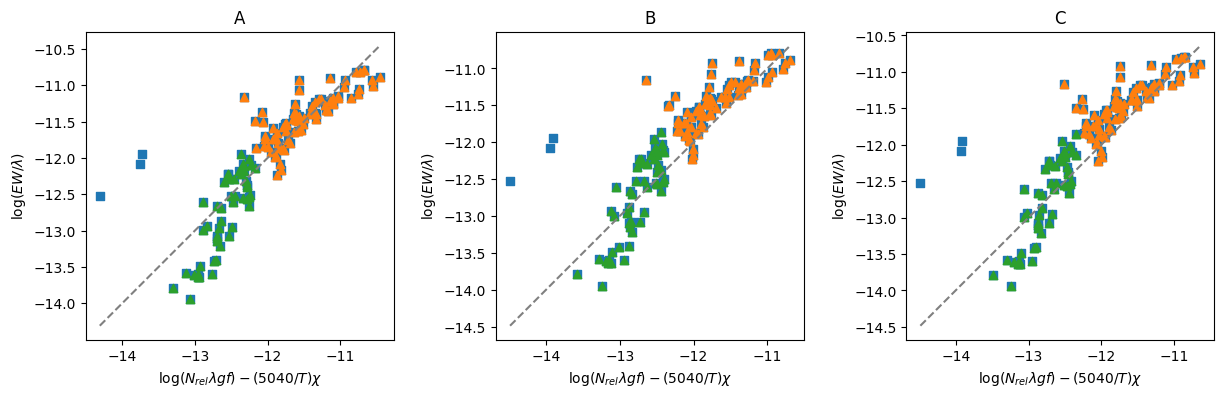

In [159]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from uncertainties import ufloat

# read data
data = pd.read_csv("iron_line_list_FINAL.csv", header=0)
data.dropna(axis=0, how="any", inplace=True)  # only take measured lines
data.drop(data[data["Breite"] >= 0.120].index, inplace=True)  # only take thin lines
#data.drop(data[np.abs(data["Error"]) >= 0.015].index, inplace=True)

# define fit function
def fitfunc(x, T, N_rel):
    xi, loggf, lam = x
    return loggf + np.log(lam) + np.log(N_rel) - 5040 / T * xi 

# prepare data for fit
data_x = np.array([data["Exc. Potential"], data["loggf"], data["Lambda"]])
data["log(Breite/Lambda)"] = np.log(data["Breite"] / data["Lambda"])

# Fit parameters for each regime
t_values = [
    (-13.7, -12, -11.9),
    (-13.7, -12.3, -11.8),
    (-13.7, -12.3, -11.8)
]
letter = ["A", "B", "C"]

x_fit, linear_regime = data_x, data
n_plots = 3
fig, ax = plt.subplots(ncols=n_plots, figsize=(15,4))
popts=[]
for i in range(n_plots):
    # Perform fit
    regime = data if i == 0 else linear_regime
    popt, pcov = sp.optimize.curve_fit(fitfunc, x_fit, regime["log(Breite/Lambda)"], p0=[6000, 1e-7])
    popts.append(popt)
    # Compute values according to the fit
    data[f"x_fit_{i+1}"] = fitfunc(data_x, *popt)

    ax[i].scatter(data[f"x_fit_{i+1}"], data["log(Breite/Lambda)"], marker="s", label="full dataset")
    
    line_45 = np.linspace(np.min(data[f"x_fit_{i+1}"]), np.max(data[f"x_fit_{i+1}"]), 200)
    ax[i].plot(line_45, line_45, ls="--", c="gray")
    # Group into regimes
    t_0, t_1, t_2 = t_values[i]
    data[f"log_reg_{i+1}"] = (data[f"x_fit_{i+1}"] >= t_1) | (data["log(Breite/Lambda)"] >= t_2)
    ax[i].scatter(data.loc[data[f"log_reg_{i+1}"], f"x_fit_{i+1}"], data.loc[data[f"log_reg_{i+1}"], "log(Breite/Lambda)"], marker="^", label="log regime")

    data[f"lin_reg_{i+1}"] = (data[f"x_fit_{i+1}"] > t_0) & (data[f"x_fit_{i+1}"] < t_1) & (data["log(Breite/Lambda)"] < t_2)
    ax[i].scatter(data.loc[data[f"lin_reg_{i+1}"], f"x_fit_{i+1}"], data.loc[data[f"lin_reg_{i+1}"], "log(Breite/Lambda)"], marker="^", label="linear regime")

    ax[i].set_box_aspect(1)
    ax[i].set_xlabel(r"$\log(N_{rel}\lambda gf)- (5040/T) \chi$")
    ax[i].set_ylabel(r"$\log(EW/\lambda)$")
    ax[i].set_title(letter[i])
    print(f"fit {i+1}:", "T: ", ufloat(popt[0], np.sqrt(pcov[0, 0])), "N_rel: ", ufloat(popt[1], np.sqrt(pcov[1, 1])))

    # Prepare data for the next fit
    linear_regime = data.loc[data[f"lin_reg_{i+1}"]]
    x_fit = np.array([linear_regime["Exc. Potential"], linear_regime["loggf"], linear_regime["Lambda"]])

    if i > 0:
        print(f"index_difference between fit {i} and fit {i+1}:",
              sorted(data[data[f"lin_reg_{i}"]].index) != sorted(data[data[f"lin_reg_{i+1}"]].index))
plt.show()

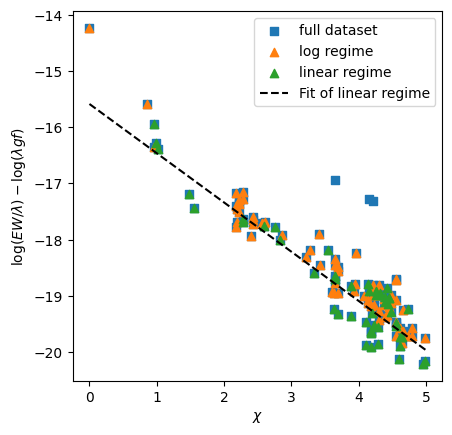

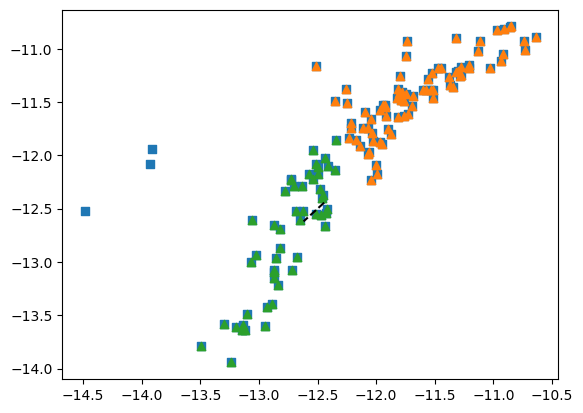

In [160]:
# plot last result with fit curves
fig, ax = plt.subplots()

ax.scatter(data["Exc. Potential"], data["log(Breite/Lambda)"] - data["loggf"]-np.log(data["Lambda"]), marker="s", label="full dataset")

# Group into regimes
log_reg = data.loc[data[f"log_reg_{i+1}"]]
ax.scatter(log_reg["Exc. Potential"], log_reg["log(Breite/Lambda)"] - log_reg["loggf"]-np.log(log_reg["Lambda"]), marker="^", label="log regime")

lin_reg = data.loc[data[f"lin_reg_{i+1}"]]
ax.scatter(lin_reg["Exc. Potential"], lin_reg["log(Breite/Lambda)"] - lin_reg["loggf"]-np.log(lin_reg["Lambda"]), marker="^", label="linear regime")

xi_range = np.linspace(np.min(data["Exc. Potential"]), np.max(data["Exc. Potential"]))
def plotfunc(xi, T, N_rel):
    return np.log(N_rel) - 5040 / T * xi 
plt.plot(xi_range, plotfunc(xi_range, *popt), "k--", label="Fit of linear regime")

ax.set_box_aspect(1)
ax.set_xlabel(r"$\chi$")
ax.set_ylabel(r"$\log(EW/\lambda) -\log(\lambda gf)$")
ax.legend()
plt.show()

# plot from above agaib
plt.scatter(data[f"x_fit_{i+1}"], data["log(Breite/Lambda)"], marker="s", label="full dataset")
plt.scatter(log_reg[f"x_fit_{i+1}"], log_reg["log(Breite/Lambda)"], marker="^", label="log regime")
plt.scatter(lin_reg[f"x_fit_{i+1}"], lin_reg["log(Breite/Lambda)"], marker="^", label="linear regime")

loggf_range = np.linspace(np.min(lin_reg["loggf"]), np.max(lin_reg["loggf"]))
lambda_range = np.linspace(np.min(lin_reg["Lambda"]), np.max(lin_reg["Lambda"]))
plot_x = plotfunc(fit_range, *popt) + loggf_range + np.log(lambda_range)
plt.plot(fitfunc(np.array([xi_range, loggf_range, lambda_range]), *popt), plot_x, "k--", label="Fit of linear regime")